In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import json
import bs4
import re
from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
# import bz2

# with bz2.open('../data_scraping/bills.json.bz2', 'r') as f:  
#     data = f.read()  
#     d = json.loads(data.decode("utf-8"))

In [3]:
# values = []

# for i in tqdm(list(d.values())):
#     dic = {}
#     soup = bs4.BeautifulSoup(i, 'html.parser')
#     content = soup.find('td', attrs = {'id':'content'}).text.strip()
#     try:
#         dic['congress'] = int(re.search('\d{2}(?=th Congress)',
#                                         content).group(0))
#         dic['type'] = re.search('(?<= Congress).+(?= Bill)', content).group(0)
#         bill_num = int(re.search('(?<=Bill No. )\d{1,}', content).group(0))
#         dic['bill_num'] = bill_num

        
#         dic['title'] = re.search(f'(?<=Bill No. {bill_num}).+(?=Filed)',
#                                  content).group(0)
#         dic['filed_on'] = re.search('(?<=Filed on ).+(?= by)',
#                                     content).group(0)
#         dic['filed_by'] = re.search('(?<=by ).+', content).group(0)
        

#         dic['long_title'] = re.search('(?<=Long title).+', content).group(0)
#         dic['scope'] = re.search('(?<=Scope).+', content).group(0)
#         dic['subjects'] = re.search('(?<=Subject\(s\)).+', content).group(0)
#         dic['primary_committee'] = re.search('(?<=Primary committee).+',
#                                              content).group(0)

#     except:
#         pass
#     values.append(dic)

100%|████████████████████████████████████████████████████████████████████████████| 15641/15641 [03:18<00:00, 78.63it/s]


In [4]:
# df = pd.DataFrame(values)

In [5]:
# df.isna().sum()

congress               0
type                   0
bill_num               0
title                  0
filed_on               0
filed_by               1
long_title             1
scope                  1
subjects             362
primary_committee    402
dtype: int64

In [8]:
# len(df)

15239

In [6]:
# df.dropna(subset=['filed_by', 'primary_committee'], inplace=True)

In [7]:
# df.isna().sum()

congress             0
type                 0
bill_num             0
title                0
filed_on             0
filed_by             0
long_title           0
scope                0
subjects             0
primary_committee    0
dtype: int64

In [10]:
# len(df)

15239

In [11]:
# df.to_pickle('bills.pkl', protocol=3)

## Preprocessing Pipeline

1. Data Cleaning
    1. Categorical Features
        1. Normalize names of categories 
        2. Convert strings of sequences of words to list of categories.
    2. Text Features
        1. Combine title and long title
        2. Natural Language Processing
            1. Removing of punctiations
            2. Removing stop words
            3. Lemmatization
    3. Convert dates to datetime columns

3. TF-IDF Vectorization Text Features for Clustering

In [12]:
df = pd.read_pickle('bills.pkl')

In [ ]:
# cols_used = ['congress', 'bill_num', 'title', 'long_title', 'filed_on',
#              'filed_by', 'primary_committee', 'scope']
# df = df[cols_used]

In [13]:
df.head()

,congress,type,bill_num,title,filed_on,filed_by,long_title,scope,subjects,primary_committee
0,13,Senate,1,SPECIAL MEASURES TO LOWER THE COST OF MEDICINE,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",AN ACT PRESCRIBING SPECIAL MEASURES TO LOWER...,National,Medicines (Lowering the Cost) Drugs/...,Health and Demography
1,13,Senate,2,THE CONSTITUTIONAL CONVENTION ACT,"June 30, 2004","Flavier, Juan M.",AN ACT CALLING FOR A CONSTITUTIONAL CONVENTIO...,National,Constitutional Convention Charte...,"Constitutional Amendments, Revision of Codes a..."
2,13,Senate,3,MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",AN ACT DECLARING THE RIGHTS AND OBLIGATIONS O...,National,Patients Rights and Obligations Magna ...,Health and Demography
3,13,Senate,4,HEALTH PROMOTION ACT OF 2004,"June 30, 2004","Flavier, Juan M., Angara, Edgardo J.",AN ACT ESTABLISHING A NATIONAL HEALTH PROMOTI...,National,National Health Promotion Institute Philip...,Government Corporations and Public Enterprises
4,13,Senate,5,INCREASING THE ALLOWABLE PERSONAL ADDITIONAL T...,"June 30, 2004","Flavier, Juan M.",AN ACT INCREASING THE ALLOWABLE PERSONAL ADDIT...,National,Taxes (Tax Exemption-Individual TaxpayerNation...,Ways and Means


## Data Cleaning

In [14]:
df_clean = df.copy()

### Categorical Features

#### filed_by

In [15]:
# TODO: Still needs a lot of cleaning

df_clean['filed_by'] = df_clean['filed_by'].str.split('.')
df_clean['filed_by'].sample(5)

15365    [Pacquiao, Emmanuel "Manny" D, ]
12597                  [Recto, Ralph G, ]
10770          [Lapid, Manuel "Lito" M, ]
5616          [Defensor Santiago, Miriam]
9073          [Defensor Santiago, Miriam]
Name: filed_by, dtype: object

#### primary_committee

In [16]:
df_clean['primary_committee'].value_counts()

Health and Demography                                                   1523
Education, Arts and Culture                                             1503
Justice and Human Rights                                                1428
Labor, Employment and Human Resources Development                        826
Public Services                                                          681
Environment and Natural Resources                                        666
Local Government                                                         640
Ways and Means                                                           546
Agriculture and Food                                                     441
Civil Service and Government Reorganization                              427
Government Corporations and Public Enterprises                           415
Constitutional Amendments, Revision of Codes and Laws                    403
Civil Service, Government Reorganization and Professional Regulation     377

In [17]:
mapper ={'Accounts': 'Accounts',
         'Agrarian Reform': 'Agriculture, Food and Agrarian Reform',
         'Agriculture and Food': 'Agriculture, Food and Agrarian Reform',
         'Agriculture, Food and Agrarian Reform': 'Agriculture, Food and Agrarian Reform',
         'Banks, Financial Institutions and Currencies': 'Banks, Financial Institutions and Currencies ',
         'Basic Education, Arts and Culture': 'Basic Education, Arts and Culture',
         'Education, Arts and Culture': 'Basic Education, Arts and Culture',
         'Civil Service and Government Reorganization': 'Civil Service, Government Reorganization and Professional Regulation ',
         'Civil Service, Government Reorganization and Professional Regulation': 'Civil Service, Government Reorganization and Professional Regulation ',
         'Constitutional Amendments and Revision of Codes': 'Constitutional Amendments and Revision of Codes',
         'Constitutional Amendments, Revision of Codes and Laws': 'Constitutional Amendments and Revision of Codes',
         'Cooperatives': 'Cooperatives',
         'Joint Congressional Oversight Committee on Cooperatives': 'Cooperatives',
         'Cultural Communities': 'Cultural Communities',
         'Economic Affairs': 'Economic Affairs',
         'Electoral Reforms  and Peoples Participation': 'Electoral Reforms and People’s Participation',
         'Energy': 'Energy',
         'Climate Change': 'Environment, Natural Resources and Climate Change',
         'Environment and Natural Resources': 'Environment, Natural Resources and Climate Change',
         'Environment, Natural Resources and Climate Change': 'Environment, Natural Resources and Climate Change',
         'Finance': 'Finance',
         'Foreign Relations': 'Foreign Relations',
         'Games and Amusement': 'Games and Amusement',
         'Games, Amusement and Sports': 'Games and Amusement',
         'Government Corporations and Public Enterprises': 'Government Corporations and Public Enterprises',
         'Health and Demography': 'Health and Demography',
         'Higher, Technical and Vocational Education': 'Higher, Technical and Vocational Education',
         'Justice and Human Rights': 'Justice and Human Rights',
         'Labor, Employment and Human Resources Development': 'Labor, Employment and Human Resources Development',
         'Local Government': 'Local Government',
         'National Defense and Security': 'National Defense and Security, Peace, Unification and Reconciliation ',
         'National Defense and Security, Peace, Unification and Reconciliation': 'National Defense and Security, Peace, Unification and Reconciliation ',
         'Peace, Unification and Reconciliation': 'National Defense and Security, Peace, Unification and Reconciliation ',
         'Public Information and Mass Media': 'Public Information and Mass Media',
         'Public Order and Dangerous Drugs': 'Public Order and Dangerous Drugs',
         'Public Order and Illegal Drugs': 'Public Order and Dangerous Drugs',
         'Public Services': 'Public Services',
         'Public Works': 'Public Works',
         'Rules': 'Rules',
         'Science and Technology': 'Science and Technology',
         'Social Justice, Welfare and Rural Development': 'Social Justice, Welfare and Rural Development',
         'Amateur Sports Competitiveness': 'Sports',
         'Sports': 'Sports',
         'Sustainable Development Goals, Innovation and Futures Thinking': 'Sustainable Development Goals, Innovation and Futures Thinking ',
         'Tourism': 'Tourism',
         'Trade and Commerce': 'Trade, Commerce and Entrepreneurship',
         'Trade, Commerce and Entrepreneurship': 'Trade, Commerce and Entrepreneurship',
         'Urban Planning, Housing and Resettlement': 'Urban Planning, Housing and Resettlement',
         'Ways and Means': 'Ways and Means',
         'Women, Children, Family Relations and Gender Equality': 'Women, Children, Family Relations and Gender Equality',
         'Youth': 'Youth ',
         'Youth, Women and Family Relations': 'Youth '}

df_clean['primary_committee'] = df_clean['primary_committee'].replace(mapper)
df_clean['primary_committee'].value_counts()

Basic Education, Arts and Culture                                        1627
Health and Demography                                                    1523
Justice and Human Rights                                                 1428
Labor, Employment and Human Resources Development                         826
Civil Service, Government Reorganization and Professional Regulation      804
Environment, Natural Resources and Climate Change                         729
Public Services                                                           681
Local Government                                                          640
Trade, Commerce and Entrepreneurship                                      629
Agriculture, Food and Agrarian Reform                                     572
Ways and Means                                                            546
Public Order and Dangerous Drugs                                          537
Constitutional Amendments and Revision of Codes                 

    2. Text Features
        1. Combine title and long title
        2. Natural Language Processing
            1. Removing of punctiations
            2. Removing stop words
            3. Lemmatization

### Text Features

#### Combine title and long title

In [25]:
combined = []
for short, long in tqdm(list(zip(df_clean["title"], df_clean['long_title']))):
    if short in long:
        combined += [long.lower()]
    else:
        combined += [short.lower() +' ' + long.lower()]

100%|████████████████████████████████████████████████████████████████████████| 15239/15239 [00:00<00:00, 585771.09it/s]


In [26]:
df_clean['combined_title'] = combined

df_clean['combined_title'].head()

0    special measures to lower the cost of medicine...
1    the constitutional convention act an act calli...
2    magna carta of patient's rights and obligation...
3    health promotion act of 2004 an act establishi...
4    increasing the allowable personal additional t...
Name: combined_title, dtype: object

#### Natural Language Processing

##### Removing of punctuations

In [27]:
import string
punc = string.punctuation.replace('-', '').replace("'", '')
table = str.maketrans(' ', ' ', punc)
stripped = [w.translate(table) for w in df_clean['combined_title']]

##### Removing stop words

In [28]:
import nltk
# nltk.download('stopwords')

In [29]:
# filter out stop words
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

no_stop_words = []
for word_list in stripped:
    word_list = word_list.split()
    words = [w for w in word_list if not w in stop_words]
    no_stop_words += [words]

#### Lemmatization

In [30]:
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

lematized = []
for word_list in no_stop_words:
    words = [lemmatizer.lemmatize(w) for w in word_list]
    lematized += [words]

In [31]:
title_cleaned = []
for i in lematized:
    title_cleaned+=[" ".join(i)]

In [32]:
df_clean['combined_title'] = title_cleaned
df_clean['combined_title'].sample(5)

11589    philippine national banana research center act...
12212    act establish national research development ex...
13530    journalists' protection act 2018 act providing...
1006     non publication source published news informat...
5337     commission human right act act strengthening f...
Name: combined_title, dtype: object

### Convert dates to datetime columns

In [33]:
df_clean['filed_on'] = pd.to_datetime(df_clean['filed_on'])
df_clean['filed_on'].head()

0   2004-06-30
1   2004-06-30
2   2004-06-30
3   2004-06-30
4   2004-06-30
Name: filed_on, dtype: datetime64[ns]

In [34]:
df_clean.to_pickle('clean_data.pkl', protocol=3)

In [35]:
df_clean.head()

,congress,type,bill_num,title,filed_on,filed_by,long_title,scope,subjects,primary_committee,combined_title
0,13,Senate,1,SPECIAL MEASURES TO LOWER THE COST OF MEDICINE,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",AN ACT PRESCRIBING SPECIAL MEASURES TO LOWER...,National,Medicines (Lowering the Cost) Drugs/...,Health and Demography,special measure lower cost medicine act prescr...
1,13,Senate,2,THE CONSTITUTIONAL CONVENTION ACT,2004-06-30,"[Flavier, Juan M, ]",AN ACT CALLING FOR A CONSTITUTIONAL CONVENTIO...,National,Constitutional Convention Charte...,Constitutional Amendments and Revision of Codes,constitutional convention act act calling cons...
2,13,Senate,3,MAGNA CARTA OF PATIENT'S RIGHTS AND OBLIGATIONS,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",AN ACT DECLARING THE RIGHTS AND OBLIGATIONS O...,National,Patients Rights and Obligations Magna ...,Health and Demography,magna carta patient's right obligation act dec...
3,13,Senate,4,HEALTH PROMOTION ACT OF 2004,2004-06-30,"[Flavier, Juan M, , Angara, Edgardo J, ]",AN ACT ESTABLISHING A NATIONAL HEALTH PROMOTI...,National,National Health Promotion Institute Philip...,Government Corporations and Public Enterprises,health promotion act 2004 act establishing nat...
4,13,Senate,5,INCREASING THE ALLOWABLE PERSONAL ADDITIONAL T...,2004-06-30,"[Flavier, Juan M, ]",AN ACT INCREASING THE ALLOWABLE PERSONAL ADDIT...,National,Taxes (Tax Exemption-Individual TaxpayerNation...,Ways and Means,increasing allowable personal additional tax e...


## TF-IDF Vectorization Text Features for Clustering

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.999, max_features=1000)
X = vectorizer.fit_transform(df_clean['combined_title']).toarray()
print(X.shape)

(15239, 1000)


## Dimensionality Reduction

In [37]:
def truncated_svd(X):
    """Return truncated SVD of X."""
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

In [38]:
features = vectorizer.get_feature_names()

In [39]:
q, s, p, nssd = truncated_svd(X)

In [51]:
def plot_svd(X_new, features, p):
    """
    Plot transformed data and features on to the first two singular vectors
    
    Parameters
    ----------
    X_new : array
        Transformed data
    featurs : sequence of str
        Feature names
    p : array
        P matrix
    """
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect='equal'), 
                           gridspec_kw=dict(wspace=0.4), dpi=150)
    ax[0].scatter(X_new[:,0], X_new[:,1])
    ax[0].set_xlabel('SV1')
    ax[0].set_ylabel('SV2')

    for feature, vec in zip(features, p):
        ax[1].arrow(0, 0, vec[0], vec[1], width=0.01, ec='none', fc='r')
        ax[1].text(vec[0], vec[1], feature, ha='center', color='r', fontsize=5)
    ax[1].set_xlim(-1, 1)
    ax[1].set_ylim(-1, 1)
    ax[1].set_xlabel('SV1')
    ax[1].set_ylabel('SV2')

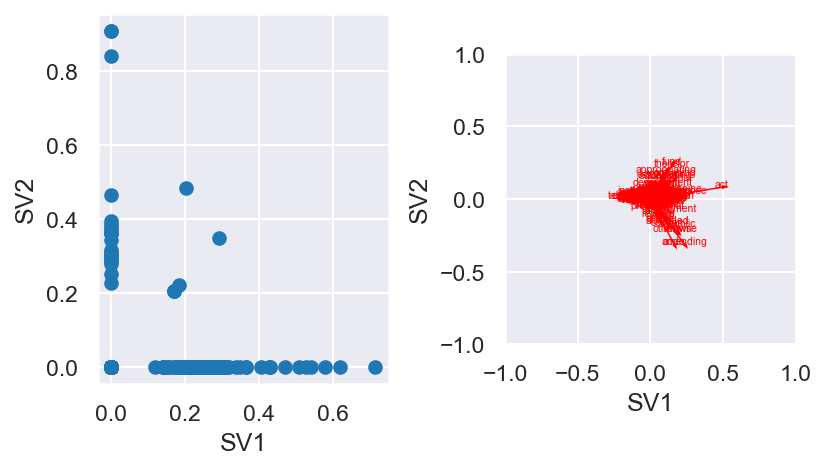

In [52]:
plot_svd(X, features, p)

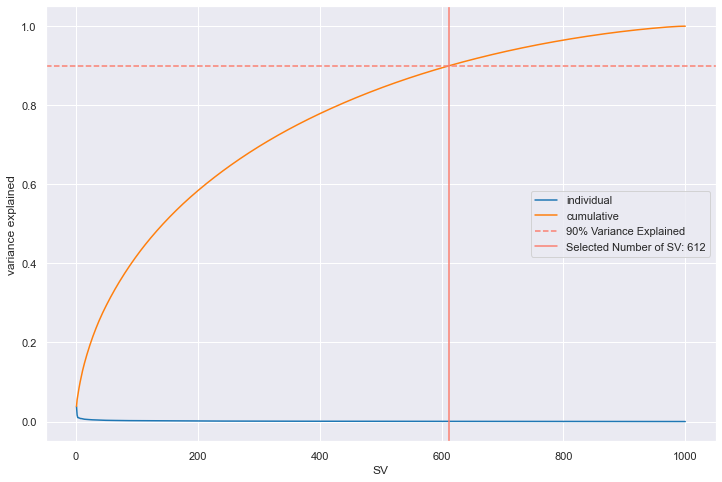

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), '-', label='cumulative')
plt.axhline(0.9, linestyle='--', color='salmon')

chosen_sv = np.argwhere(nssd.cumsum() >= 0.9)[0][0]

plt.axvline(chosen_sv, color='salmon')

ax.legend(['individual', 'cumulative', '90% Variance Explained',
           f'Selected Number of SV: {chosen_sv}' ])
# ax.set_ylim(0, 1)

ax.set_xlabel('SV')

ax.set_ylabel('variance explained');

In [43]:
def project_svd(q, s, k):
    """Returns the projected result of SVD."""
    return q[:,:k].dot(s[:k,:k])

In [44]:
X_svd = project_svd(q, s, chosen_sv)
X_svd.shape

(15239, 612)

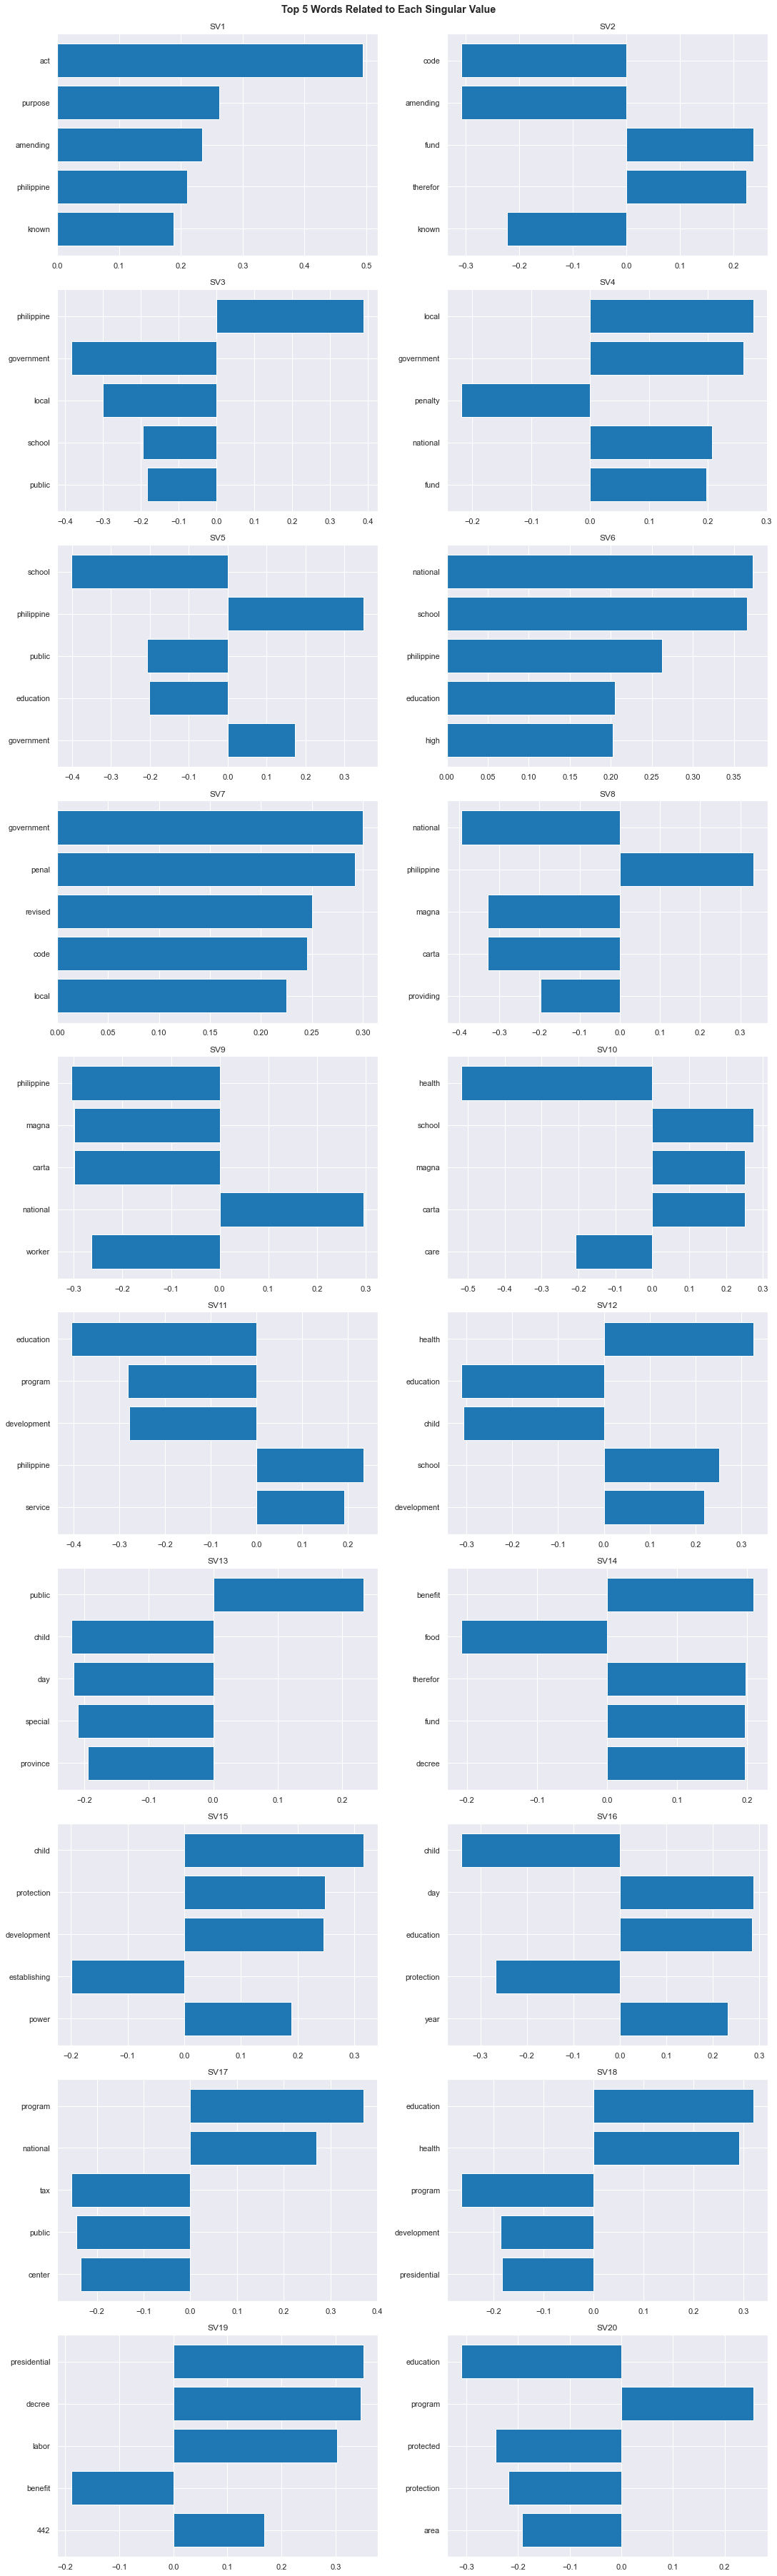

In [54]:
num_sv = 20
cols = 2
fig, axes = plt.subplots(int(num_sv/cols), cols, figsize=(15, 50),
                        constrained_layout=True)
axes = axes.ravel()

for i, ax in zip(range(0, num_sv), axes):
    sv_num = i+1
    order = np.argsort(np.abs(p[:, i]))[-5:]
    ax.barh([features[o] for o in order], p[order, i])
    ax.set_title(f'SV{sv_num}')
    
fig.suptitle("Top 5 Words Related to Each Singular Value",  
             fontweight="bold");

## Clustering

In [42]:
# from scipy.cluster.hierarchy import linkage, dendrogram
# Z = linkage(X_svd, method='ward', optimal_ordering=True)

In [43]:
# fig, ax = plt.subplots()
# dn = dendrogram(Z, ax=ax, p=20, truncate_mode='level', color_threshold=4.3)
# ax.axhline(4.3, linestyle='--', color='salmon')
# ax.set_xlabel('Samples')
# ax.set_title("Dendogram for Doing Agglomerative "
#              "Clustering with Ward's Method")
# ax.set_ylabel(r'$\Delta$');

In [44]:
# fig, ax = plt.subplots()
# dn = dendrogram(Z, ax=ax, p=20, truncate_mode='level', color_threshold=4.3)
# ax.axhline(4.3, linestyle='--', color='salmon')
# ax.set_xlabel('Samples')
# ax.set_title("Dendogram for Doing Agglomerative "
#              "Clustering with Ward's Method")
# ax.set_ylabel(r'$\Delta$');

In [46]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [55]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                linkage='ward')
model = model.fit(X_svd)

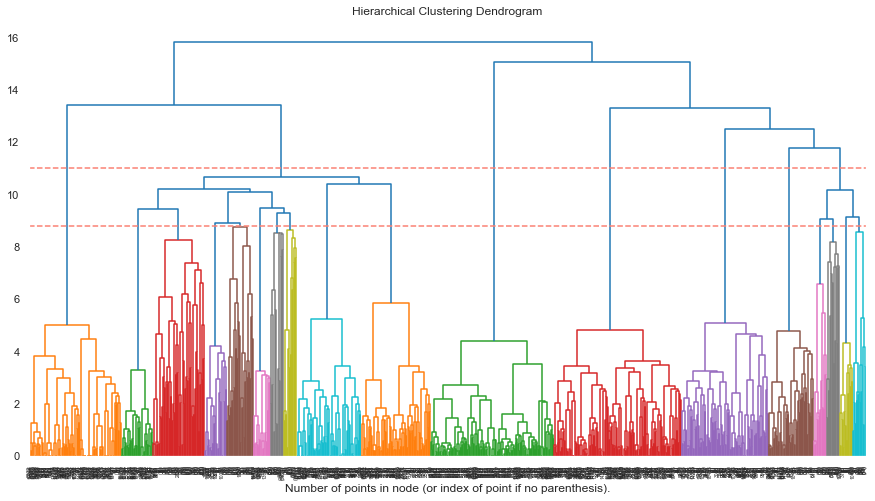

In [70]:
# plot the top three levels of the dendrogram
plt.figure(figsize=(15, 8))
plot_dendrogram(model, truncate_mode='level', p=10, color_threshold=8.8)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(11, color='salmon', linestyle='--')
plt.axhline(8.8, color='salmon', linestyle='--')
plt.show()

In [71]:
model2 = AgglomerativeClustering(distance_threshold=11, n_clusters=None, 
                                linkage='ward')

model3 = AgglomerativeClustering(distance_threshold=8.8, n_clusters=None, 
                                linkage='ward')

In [72]:
models = [model2, model3]

for i, model in zip(['ward_a', 'ward_b'],models):
    df_clean[f'clustering_{i}'] = model.fit_predict(X_svd)

In [73]:
df_clean['clustering_ward_b'].value_counts()

2     7327
1     2253
6     1547
10     824
0      677
9      347
5      313
14     299
4      252
16     200
3      195
11     195
15     172
8      160
7      159
17     131
12     110
13      78
Name: clustering_ward_b, dtype: int64

In [74]:
df_clean.to_pickle('clusters_added.pkl', protocol=3)
# df_clean = pd.read_pickle('clusters_added.pkl')

## Analyzing the Clusters

1. Word Cloud cluster c
2. 5 samples per cluster c dataframe
3. Interpretation of each cluster 
4. TSNE Plot